In [3]:
from gin_train.trainers import KerasTrainer
from kipoi_cadd.data import (CaddDataset, cadd_train_valid_data, cadd_serialize_string_row,
                             train_test_split_indexes)
from kipoi_cadd.utils import load_pickle, dump_to_pickle
from kipoi_cadd.config import get_data_dir
import pandas as pd
import numpy as np
from random import shuffle
from kipoi_cadd.models import logistic_regression_scikit, logistic_regression_keras
from gin_train.metrics import ClassificationMetrics
from kipoi_cadd.data_utils import create_lmdb_from_iterator
from sklearn.model_selection import train_test_split
import lmdb
from joblib import Parallel, delayed
import pyarrow as pa
from tqdm import tqdm
import blosc
import matplotlib.pyplot as plt
%load_ext line_profiler

In [4]:
lmdb_dir = "/s/project/kipoi-cadd/data/raw/v1.3/training_data/lmdb"

In [6]:
ds = CaddDataset(lmdb_dir, "/s/project/kipoi-cadd/data/raw/v1.3/training_data/variant_ids.pkl")
it = ds.batch_train_iter(batch_size=256, num_workers=10)
batch = next(it)

In [12]:
next(ds.batch_iter(batch_size=10, shuffle=True))

{'inputs': array([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 'targets': array([1., 1., 0., 1., 0., 0., 1., 0., 0., 0.]),
 'metadata': {'variant_id': array(["3:14064880:G:['C']", "4:94628524:T:['G']", "13:89491811:G:['A']",
         "18:10457071:A:['G']", "X:40583166:A:['T']", "7:39541347:C:['G']",
         "8:23152524:A:['G']", "8:52353048:C:['T']", "10:51673843:C:['G']",
         "X:11648445:A:['G']"], dtype='<U19')}}

## Check compression ratios of blosc for different batch sizes

In [ ]:
%%time
batch = next(ds.batch_train_iter(batch_size=256, num_workers=10))
buff = pa.serialize(batch).to_buffer()
blzpacked = blosc.compress(buff, typesize=8, cname='blosclz')
print("Buff", len(buff), "blosclz", len(blzpacked))
print(round(len(buff) / float(len(blzpacked)), 3))

In [ ]:
%%time
batch = next(ds.batch_train_iter(batch_size=512, num_workers=10))
buff = pa.serialize(batch).to_buffer()
blzpacked = blosc.compress(buff, typesize=8, cname='blosclz')
print("Buff", len(buff), "blosclz", len(blzpacked))
print(round(len(buff) / float(len(blzpacked)), 3))

In [ ]:
%%time
batch = next(ds.batch_train_iter(batch_size=1024, num_workers=10))
buff = pa.serialize(batch).to_buffer()
blzpacked = blosc.compress(buff, typesize=8, cname='blosclz')
print("Buff", len(buff), "blosclz", len(blzpacked))
print(round(len(buff) / float(len(blzpacked)), 3))

In [ ]:
%%time
batch = next(ds.batch_train_iter(batch_size=2048, num_workers=10))
buff = pa.serialize(batch).to_buffer()
blzpacked = blosc.compress(buff, typesize=8, cname='blosclz')
print("Buff", len(buff), "blosclz", len(blzpacked))
print(round(len(buff) / float(len(blzpacked)), 3))

In [ ]:
plot_data = {'batch_size': [], 'compression_ratio': []}
for i in [32, 64, 128, 256, 512, 1024, 2048]:
    batch = next(ds.batch_train_iter(batch_size=i, num_workers=10))
    buff = pa.serialize(batch).to_buffer()
    blzpacked = blosc.compress(buff, typesize=8, cname='blosclz')
    ratio = round(len(buff) / float(len(blzpacked)), 3)
    plot_data['batch_size'].append(i)
    plot_data['compression_ratio'].append(ratio)

In [34]:
plot_data

{'batch_size': [32, 64, 128, 256, 512, 1024, 2048],
 'compression_ratio': [34.136, 36.324, 36.149, 37.036, 35.821, 31.704, 29.323]}

## Checking different compression ratios for batch sizes

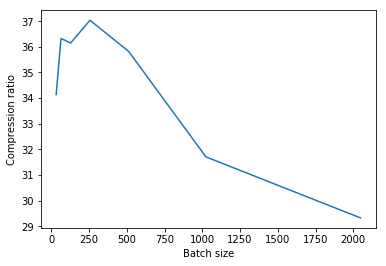

In [36]:
plt.plot(plot_data['batch_size'], plot_data['compression_ratio'])
plt.ylabel('Compression ratio')
plt.xlabel('Batch size')
plt.show()

In [55]:
from collections import OrderedDict
batch = OrderedDict()
batch[0] = {"row_nrs": [1,2], "variant_ids":["1:380798:A:['G']", "1:380798:A:['G']"]}
batch[1] = {"row_nrs": [3,4], "variant_ids":["1:33450798:A:['G']", "1:33450798:A:['G']"]}
batch
#pd.DataFrame(batch).values

OrderedDict([(0,
              {'row_nrs': [1, 2],
               'variant_ids': ["1:380798:A:['G']", "1:380798:A:['G']"]}),
             (1,
              {'row_nrs': [3, 4],
               'variant_ids': ["1:33450798:A:['G']", "1:33450798:A:['G']"]})])

In [ ]:
ds2 = CaddDataset(lmdb_dir, "/s/project/kipoi-cadd/data/raw/v1.3/training_data/variant_ids.pkl")
batch = next(ds2.batch_train_iter(batch_size=256, num_workers=10))
batch